## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate = False):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)                                
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)                                
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)          
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128, 256]
MOMENTUM = 0.95
PRE_ACT = [True, False]

In [9]:
results = {}
for i, (pre, bs) in enumerate(itertools.product(PRE_ACT, BATCH_SIZE)):
    print("Numbers of exp: %i, preact: %s, batch_size: %i" % (i, pre, bs))    
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate =pre, )
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    exp_name_tag = ("pre:%s, bs:%i" % (pre, bs))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, preact: True, batch_size: 128
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_5 (Activation)  

50000/50000 [==============================] - 11s 215us/step - loss: 0.0583 - acc: 0.9856 - val_loss: 2.7614 - val_acc: 0.4794
Epoch 47/50
50000/50000 [==============================] - 11s 216us/step - loss: 0.0603 - acc: 0.9844 - val_loss: 2.9856 - val_acc: 0.4660
Epoch 48/50
50000/50000 [==============================] - 11s 223us/step - loss: 0.0675 - acc: 0.9811 - val_loss: 2.9629 - val_acc: 0.4694
Epoch 49/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.0593 - acc: 0.9844 - val_loss: 3.2035 - val_acc: 0.4518
Epoch 50/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.0521 - acc: 0.9864 - val_loss: 2.8702 - val_acc: 0.4858
Numbers of exp: 1, preact: True, batch_size: 256
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________

50000/50000 [==============================] - 7s 140us/step - loss: 0.0682 - acc: 0.9902 - val_loss: 2.5671 - val_acc: 0.4721
Epoch 42/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.0616 - acc: 0.9921 - val_loss: 2.6724 - val_acc: 0.4581
Epoch 43/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.0599 - acc: 0.9919 - val_loss: 2.4927 - val_acc: 0.4871
Epoch 44/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.0500 - acc: 0.9946 - val_loss: 2.5688 - val_acc: 0.4689
Epoch 45/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.0465 - acc: 0.9949 - val_loss: 2.5905 - val_acc: 0.4810
Epoch 46/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.0428 - acc: 0.9962 - val_loss: 2.5146 - val_acc: 0.4811
Epoch 47/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.0384 - acc: 0.9963 - val_loss: 2.6027 - val_acc: 0.4858
Epoch 48/50
50000/50000 [==============

50000/50000 [==============================] - 11s 216us/step - loss: 0.4187 - acc: 0.8562 - val_loss: 2.2649 - val_acc: 0.4627
Epoch 37/50
50000/50000 [==============================] - 12s 240us/step - loss: 0.4063 - acc: 0.8597 - val_loss: 2.2405 - val_acc: 0.4430
Epoch 38/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.3927 - acc: 0.8635 - val_loss: 2.2173 - val_acc: 0.4589
Epoch 39/50
50000/50000 [==============================] - 11s 227us/step - loss: 0.3652 - acc: 0.8737 - val_loss: 2.2453 - val_acc: 0.4705
Epoch 40/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.3556 - acc: 0.8789 - val_loss: 2.3184 - val_acc: 0.4542
Epoch 41/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.3424 - acc: 0.8829 - val_loss: 2.3709 - val_acc: 0.4613
Epoch 42/50
50000/50000 [==============================] - 11s 222us/step - loss: 0.3297 - acc: 0.8870 - val_loss: 2.3705 - val_acc: 0.4482
Epoch 43/50
50000/50000 [=======

50000/50000 [==============================] - 7s 134us/step - loss: 0.4552 - acc: 0.8541 - val_loss: 2.1205 - val_acc: 0.4482
Epoch 32/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.4345 - acc: 0.8614 - val_loss: 1.9513 - val_acc: 0.4622
Epoch 33/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.4136 - acc: 0.8686 - val_loss: 1.9041 - val_acc: 0.4693
Epoch 34/50
50000/50000 [==============================] - 7s 137us/step - loss: 0.3921 - acc: 0.8756 - val_loss: 2.0443 - val_acc: 0.4771
Epoch 35/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.3646 - acc: 0.8871 - val_loss: 2.0801 - val_acc: 0.4689
Epoch 36/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.3584 - acc: 0.8878 - val_loss: 2.0660 - val_acc: 0.4653
Epoch 37/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.3357 - acc: 0.8951 - val_loss: 2.1207 - val_acc: 0.4669
Epoch 38/50
50000/50000 [==============

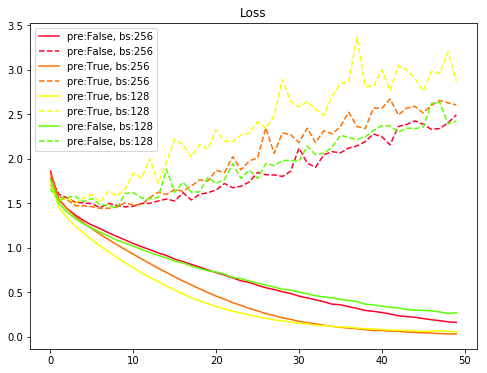

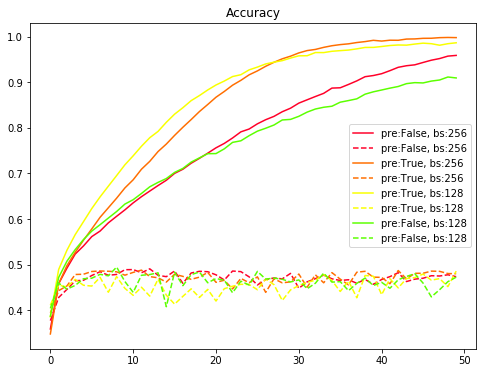

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 10

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()